# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *
from structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

#df_raw = pd.read_feather('tmp/raw')
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [7]:
set_rf_samples(50000)

In [8]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20567183954906232, 0.2471043567351633, 0.9115934402052077, 0.8909542411355116, 0.8946061318295352]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [9]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 4.01 s


(9.274191256130427, 0.3606679314998668)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [11]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

Exception in thread Thread-42:
Traceback (most recent call last):
  File "C:\Users\Kalmerrick\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Kalmerrick\Anaconda3\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Kalmerrick\Anaconda3\lib\concurrent\futures\process.py", line 295, in _queue_management_worker
    shutdown_worker()
  File "C:\Users\Kalmerrick\Anaconda3\lib\concurrent\futures\process.py", line 253, in shutdown_worker
    call_queue.put_nowait(None)
  File "C:\Users\Kalmerrick\Anaconda3\lib\multiprocessing\queues.py", line 129, in put_nowait
    return self.put(obj, False)
  File "C:\Users\Kalmerrick\Anaconda3\lib\multiprocessing\queues.py", line 83, in put
    raise Full
queue.Full



BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(9.274191256130427, 0.3606679314998668)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

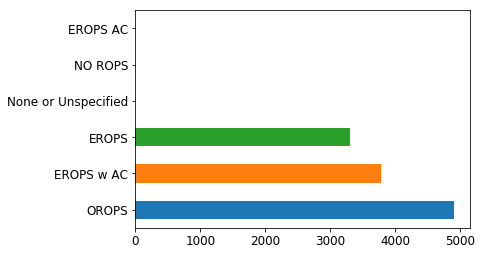

In [12]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [13]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838163,0.277152
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574379,0.267151
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682218,0.220276


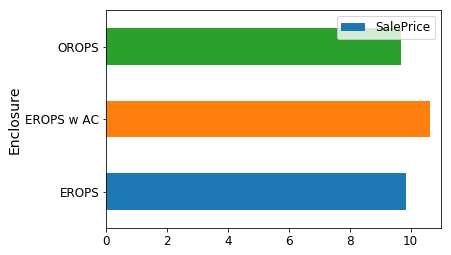

In [14]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

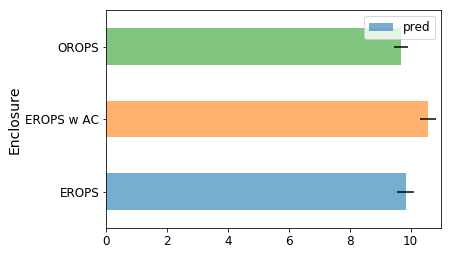

In [15]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

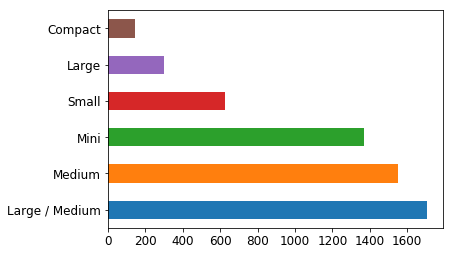

In [16]:
raw_valid.ProductSize.value_counts().plot.barh();

In [17]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.873760,0.355959
Large,10.470589,10.381314,0.364447
Large / Medium,10.691871,10.648577,0.302944
Medium,10.681511,10.623386,0.289034
Mini,9.535147,9.559628,0.255241
Small,10.324448,10.318836,0.309845


In [18]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.036051
Large             0.035106
Small             0.030027
Large / Medium    0.028449
Medium            0.027207
Mini              0.026700
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [19]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.173480
37,Coupler_System,0.115765
13,ProductSize,0.101308
14,fiProductClassDesc,0.087539
2,ModelID,0.055205
63,saleElapsed,0.050189
10,fiSecondaryDesc,0.043525
38,Grouser_Tracks,0.041540
39,Hydraulics_Flow,0.036126
19,Enclosure,0.033035


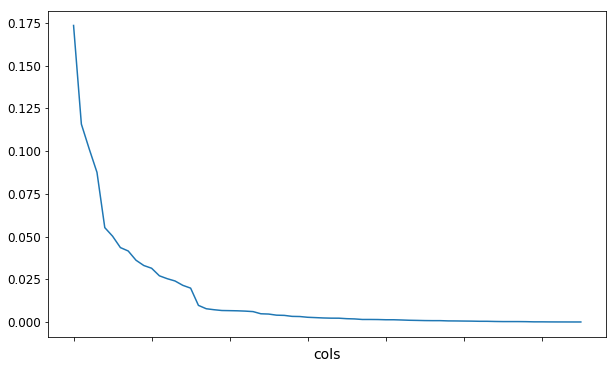

In [20]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [21]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

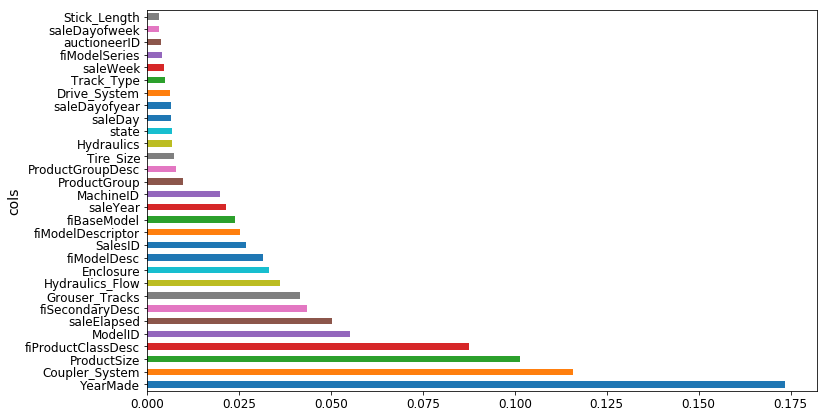

In [22]:
plot_fi(fi[:30]);

In [23]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [24]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [25]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.206752724480397, 0.24538929300819368, 0.9106617772821194, 0.8924626840204417, 0.8943105136565059]


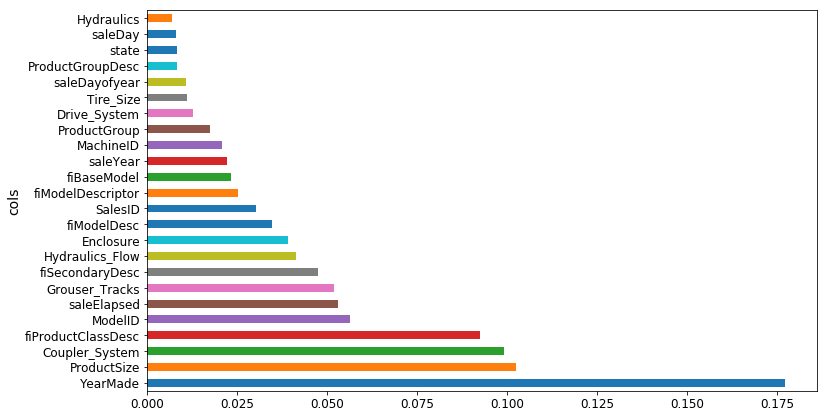

In [26]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

In [27]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20791847633779417, 0.2540672337734919, 0.9096514901614472, 0.8847223028442543, 0.8918385208407684]


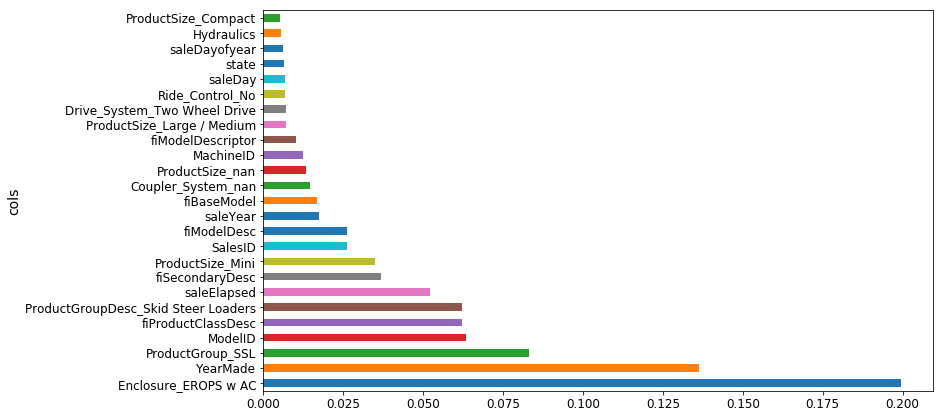

In [28]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [29]:
from scipy.cluster import hierarchy as hc

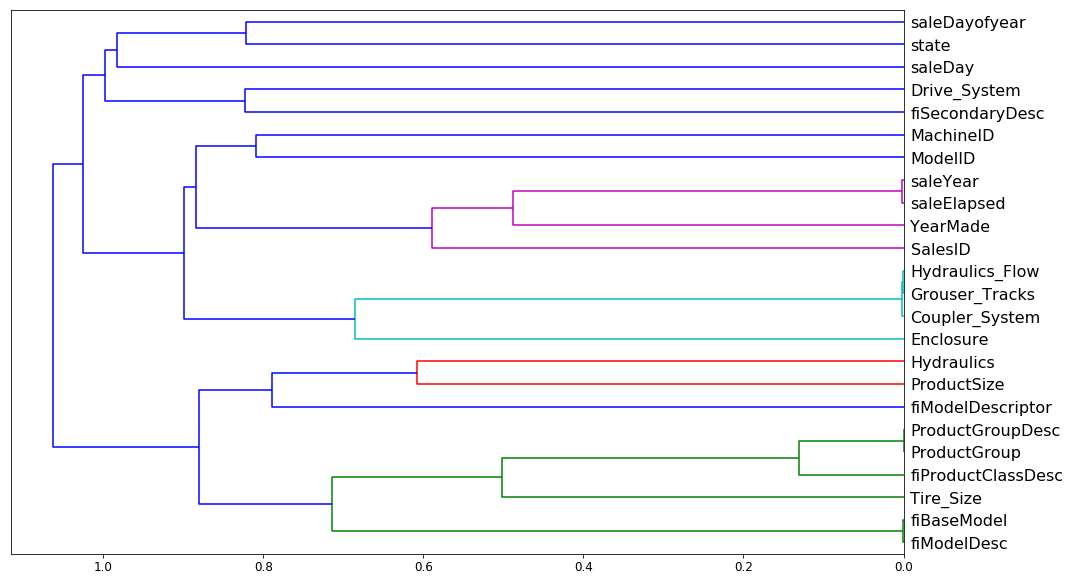

In [30]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [31]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [32]:
get_oob(df_keep)

0.8901787307050467

Now we try removing each variable one at a time.

In [33]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8891792913268669
saleElapsed 0.8871508201447811
fiModelDesc 0.8885439500183535
fiBaseModel 0.8890705991928906
Grouser_Tracks 0.8905277925739021
Coupler_System 0.8901313494405555


It looks like we can try one from each group for removal. Let's see what that does.

In [34]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8880047308063856

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [35]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [36]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [37]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [38]:
reset_rf_samples()

In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12577224901159673, 0.22858257325012038, 0.9669398758726583, 0.9066887066880913, 0.9085128831093967]


# Partial dependence

In [40]:
from pdpbox import pdp
from plotnine import *

ModuleNotFoundError: No module named 'pdpbox'

In [41]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [42]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

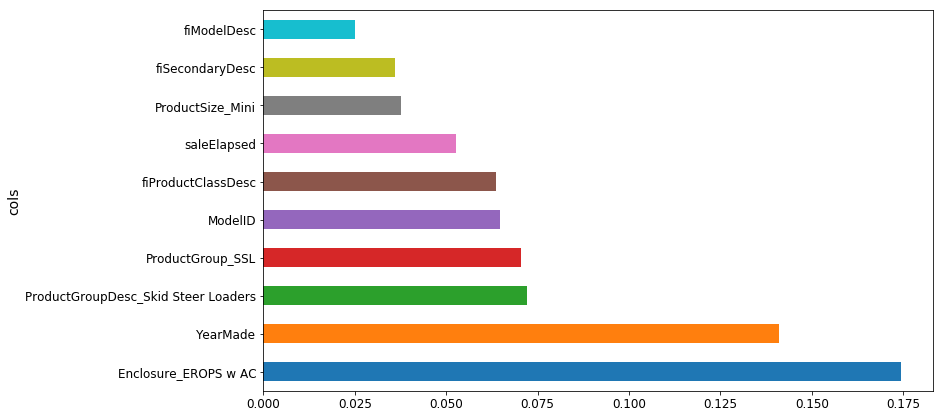

In [43]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

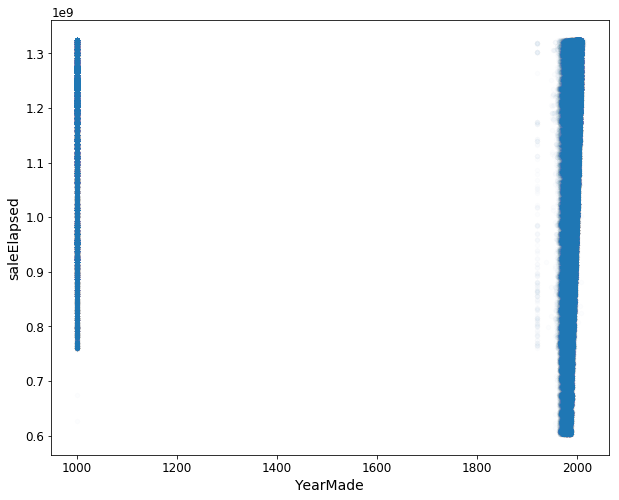

In [44]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [45]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [46]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

NameError: name 'ggplot' is not defined

In [47]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [48]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [49]:
plot_pdp('YearMade')

NameError: name 'pdp' is not defined

In [50]:
plot_pdp('YearMade', clusters=5)

NameError: name 'pdp' is not defined

In [51]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

NameError: name 'pdp' is not defined

In [52]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

NameError: name 'pdp' is not defined

In [53]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

C:\Users\Kalmerrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Kalmerrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


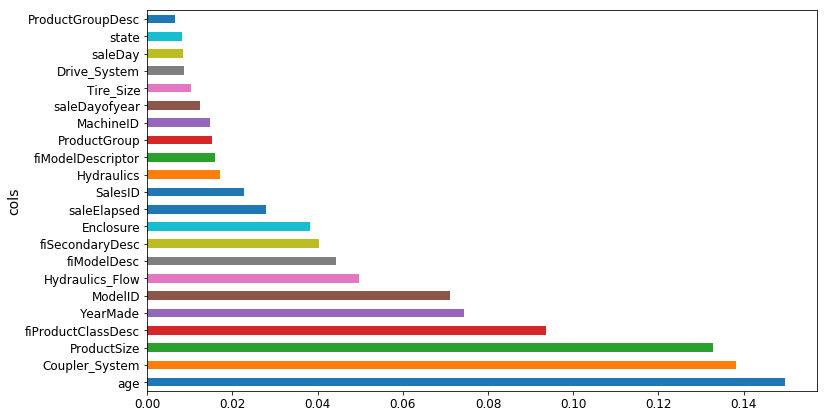

In [54]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [55]:
from treeinterpreter import treeinterpreter as ti

ModuleNotFoundError: No module named 'treeinterpreter'

In [56]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [57]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,          0,    2300944,          4,          4,          0,
                12,         35,         16,        259,          0,         11]], dtype=int64)

In [58]:
prediction, bias, contributions = ti.predict(m, row)

NameError: name 'ti' is not defined

In [59]:
prediction[0], bias[0]

NameError: name 'prediction' is not defined

In [60]:
idxs = np.argsort(contributions[0])

NameError: name 'contributions' is not defined

In [61]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

NameError: name 'idxs' is not defined

In [62]:
contributions[0].sum()

NameError: name 'contributions' is not defined

# Extrapolation

In [63]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

C:\Users\Kalmerrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999825490807105

In [65]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.732542
5,saleElapsed,0.188291
12,MachineID,0.066911
4,ModelID,0.002743
9,fiModelDesc,0.002557
0,YearMade,0.001629
19,saleDayofyear,0.001581
16,Hydraulics,0.000915
7,Hydraulics_Flow,0.000710
1,Coupler_System,0.000620


In [66]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [67]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [68]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [69]:
x.drop(feats, axis=1, inplace=True)

In [70]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9785478342162668

In [71]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.236357
0,YearMade,0.186155
16,saleDayofyear,0.151569
4,ModelID,0.079145
8,fiModelDesc,0.063233
15,saleDay,0.058437
14,state,0.054978
3,fiProductClassDesc,0.033540
5,fiSecondaryDesc,0.025389
7,Enclosure,0.021696


In [72]:
set_rf_samples(50000)

In [73]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [74]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20772366928667846, 0.24706188678823732, 0.90982071303927, 0.8909917214104216, 0.8933041361150194]


In [75]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20896905606318159, 0.246216633182642, 0.9087361495138291, 0.8917363285744215, 0.8926184419156272]
saleElapsed
[0.21423557227390705, 0.2549380049100361, 0.9040780510974712, 0.8839307603207153, 0.8870852504481531]
MachineID
[0.2069327961641251, 0.2457226952614834, 0.9105060909195614, 0.8921702707754857, 0.8948790506835048]
age
[0.20876996731309558, 0.2467181132539096, 0.9089099642498555, 0.8912948688528132, 0.8925275417958892]
YearMade
[0.20879642670055548, 0.2509731595375963, 0.9088868733875681, 0.8875129492895519, 0.8924301511999658]
saleDayofyear
[0.2092740823206871, 0.2449633079364626, 0.9084695245085491, 0.8928357200990577, 0.892395377938858]


In [76]:
reset_rf_samples()

In [77]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1384629830209575, 0.2182317116327116, 0.959931582202343, 0.9149481642437471, 0.9092382408116126]


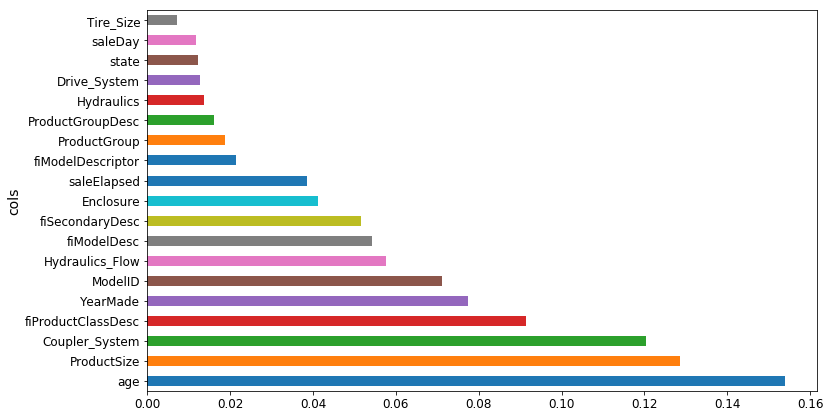

In [78]:
plot_fi(rf_feat_importance(m, X_train));

In [79]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [80]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 3min 18s
[0.08026184225564377, 0.21131075086890724, 0.9865366519276524, 0.9202572588414842, 0.91442667244133]
